# Import Packages

In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.animation as animation
import json
import time
import threading
import tqdm
from tqdm import tqdm
from tqdm import trange
import datetime

# Create Map
Create a map for the Q-learning algorithm to try. You can choose any grid size, but the larger the grid, the more compute it will take. I would suggest around an 8x8 to 12x12 grid.

In [2]:
!./map_generator

pygame 2.1.0 (SDL 2.0.16, Python 3.10.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Importing Map Array and Displaying Map
<br>

In [3]:
# Load the saved map
with open("map_data.json", "r") as f:
    rewards = np.array(json.load(f))

#rewards[rewards == 1000] = 500

environment_rows = rewards.shape[0]
environment_columns = rewards.shape[1]

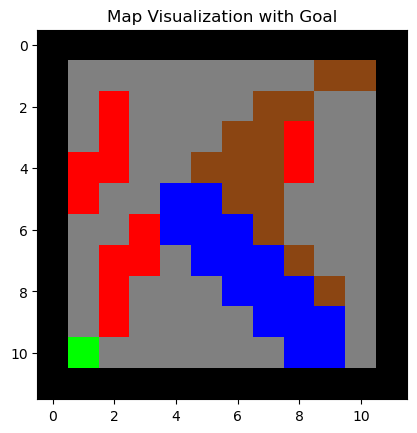

In [4]:
# Define the colormap for the grid values
cmap = colors.ListedColormap(['black', 'red', (0.5451, 0.2706, 0.0745), 'blue', 'gray', (0,1,0)])
# Bounds now account for the actual range of values, with small gaps between to handle exact matching
bounds = [-1000.5, -100.5, -99.5, -49.5, -9, -0.5, 2000.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Create the plot
plt.imshow(rewards, cmap=cmap, norm=norm)


# Display the plot
plt.title("Map Visualization with Goal")
plt.show()



# Visualization Functions
<br>

In [5]:
def graph(q_table, save=False, title=""):
    # Define the colormap for the grid values
    #fig, ax = plt.subplots(figsize=(8, 8), dpi=200)  # Increased figure size and DPI

    cmap = colors.ListedColormap(['black', 'red', (0.5451, 0.2706, 0.0745), 'blue', 'gray', (0,1,0)])
    # Bounds now account for the actual range of values, with small gaps between to handle exact matching
    bounds = [-1000.5, -100.5, -99.5, -49.5, -9, -0.5, 1000.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    
    # Create the plot for rewards
    plt.imshow(rewards, cmap=cmap, norm=norm)
    
    # Calculate the optimal direction from Q-table
    # Directions: up (0), right (1), down (2), left (3)
    optimal_directions = np.argmax(q_table, axis=2)
    
    # Initialize arrays for arrow direction (dx, dy) at each grid point
    dx = np.zeros_like(optimal_directions, dtype=float)
    dy = np.zeros_like(optimal_directions, dtype=float)
    
    # Define movement deltas for [up, right, down, left]
    move_map = {
        0: (0, -1),  # up
        1: (1, 0),   # right
        2: (0, 1),   # down
        3: (-1, 0),  # left
    }

    # Fill in dx, dy based on optimal directions, but only if the sum of Q-values is not zero
    for i in range(optimal_directions.shape[0]):
        for j in range(optimal_directions.shape[1]):
            if np.sum(q_table[i, j]) != 0:  # Check if the Q-values are non-zero
                direction = optimal_directions[i, j]
                dx[i, j], dy[i, j] = move_map[direction]
    
    # Create a meshgrid for plotting arrows
    x, y = np.meshgrid(np.arange(optimal_directions.shape[1]), np.arange(optimal_directions.shape[0]))
    
    # Plot arrows using quiver, only for non-zero vectors
    plt.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1, color='black')
    plt.title(title)

    if save:
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"images/plot_{timestamp}.png"
        plt.savefig(filename, format='png')
        
    # Display the plot with arrows
    plt.show()

In [6]:
def graph_path(path):
    # Define the colormap for the grid values
    cmap = colors.ListedColormap(['black', 'red', (0.5451, 0.2706, 0.0745), 'blue', 'gray', (0,1,0)])
    bounds = [-1000.5, -100.5, -99.5, -49.5, -9, -0.5, 1000.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # Create the plot for rewards
    plt.imshow(rewards, cmap=cmap, norm=norm)

    move_map = {
        0: (0, -1),  # up
        1: (1, 0),   # right
        2: (0, 1),   # down
        3: (-1, 0),  # left
    }

    # Now plot the path taken by the robot
    path_x = [pos[1] for pos in path]
    path_y = [pos[0] for pos in path]
    
    # Create arrows for the robot's path
    for i in range(len(path) - 1):
        start_x, start_y = path_x[i], path_y[i]
        end_x, end_y = path_x[i + 1], path_y[i + 1]
        plt.arrow(start_x, start_y, end_x - start_x, end_y - start_y, color='yellow', head_width=0.2)

    # Display the plot with arrows
    plt.show()


# Q-Learning helper functions
<br>

In [7]:
# define actions
# we will use numeric (index) to represent the actions
# 0 = up, 1 = right, 2 = down, 3 = left
actions = ['up', 'right', 'down', 'left']

In [8]:
# because we will end the episode if we reach Goal
def is_terminal_state(current_row_index, current_column_index):
    if rewards[current_row_index, current_column_index] != np.max(rewards): # it is not terminal if the rewards is -1
        return False
    else:
        return True

# this starting location must not be on the road
def get_starting_location():
    current_row_index = np.random.randint(environment_rows)       # get a random row index
    current_column_index = np.random.randint(environment_columns) # get a random column index
    
    while rewards[current_row_index, current_column_index] != -1:  # True if it is terminal
        current_row_index = np.random.randint(environment_rows)        # repeat to get another random row index
        current_column_index = np.random.randint(environment_columns)  # repeat to get another random row index
    return current_row_index, current_column_index     # returns a random starting location that is not terminal


# define an epsilon greedy algorithm for deciding the next action
def get_next_action(current_row_index, current_column_index, epsilon):
    if np.random.random() < epsilon: # choose the action with the highest q_values
        return np.random.randint(4)
    else:                            # choose a random action
        return np.argmax(q_values[current_row_index, current_column_index])


# define a function that will get the next location based on the chosen action
# refer to how the board is drawn physically, with the rows and columns
def get_next_location(current_row_index, current_column_index, action_index):
    new_row_index = current_row_index
    new_column_index = current_column_index
    if actions[action_index] == 'up' and current_row_index > 0:
        new_row_index -= 1
    elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
        new_column_index += 1
    elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
        new_row_index += 1
    elif actions[action_index] == 'left' and current_column_index > 0:
        new_column_index -= 1
    return new_row_index, new_column_index


# Define a function that will get the shortest path that is on the white tiles 
def get_shortest_path(start_row_index, start_column_index):
    i = 0
    if is_terminal_state(start_row_index, start_column_index): # check if it is on Goal or Cliff
        return []                                              # if yes, there are no available steps
    
    else: #if this is a 'legal' starting location
        current_row_index, current_column_index = start_row_index, start_column_index
        shortest_path = []
        shortest_path.append([current_row_index, current_column_index])    # add the current coordinate to the list

    while not is_terminal_state(current_row_index, current_column_index):  # repeat until we reach Goal or Cliff
        action_index = get_next_action(current_row_index, current_column_index, 1.) 
        # get next coordinate  
        
        current_row_index, current_column_index = get_next_location(current_row_index, current_column_index, action_index)
        # update that next coordinate as current coordinate
        
        shortest_path.append([current_row_index, current_column_index])   
        # add the current coordinate to the list

        i += 1
        if i > 100:
            return 0;
    return shortest_path

In [9]:
def q_learn_single(epsilon = 0.9, discount_factor = 0.9, learning_rate = 0.9, epochs = 1000,):
    q_values = np.zeros((environment_rows, environment_columns, 4))
    
    for episode in tqdm(range(epochs), desc="Training Progress", unit="epochs", ncols=100):  # Adjust `ncols` to shorten the bar
        row_index, column_index = get_starting_location()

        while not is_terminal_state(row_index, column_index):
            # choose which action to take (i.e., where to move next)
            action_index = get_next_action(row_index, column_index, epsilon)

            # perform the chosen action, and transition to the next state / next location
            old_row_index, old_column_index = row_index, column_index  # store the old row and column indexes
            row_index, column_index = get_next_location(row_index, column_index, action_index)

            # receive the reward for moving to the new state, and calculate the temporal difference
            reward = rewards[row_index, column_index]
            old_q_value = q_values[old_row_index, old_column_index, action_index]
            temporal_difference = reward + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value

            # update the Q-value for the previous state and action pair
            new_q_value = old_q_value + (learning_rate * temporal_difference)
            q_values[old_row_index, old_column_index, action_index] = new_q_value

    print('Training complete!')

    return q_values


In [10]:
def q_learn_single(epsilon = 0.9, discount_factor = 0.9, learning_rate = 0.9, epochs = 1000):
    # Initialize the Q-table with zeros for each state-action pair
    # The shape is (environment_rows, environment_columns, 4) 
    # where 4 represents 4 possible actions (e.g., up, down, left, right)
    q_values = np.zeros((environment_rows, environment_columns, 4))
    
    # Iterate through a number of episodes (i.e., learning cycles)
    for episode in tqdm(range(epochs), desc="Training Progress", unit="epochs", ncols=100):
        # Start each episode by selecting a random starting location in the environment
        row_index, column_index = get_starting_location()

        # Continue taking actions until the agent reaches a terminal state
        while not is_terminal_state(row_index, column_index):
            # Choose the next action based on an epsilon-greedy policy
            # This function should balance exploration (random) vs exploitation (best known action)
            action_index = get_next_action(row_index, column_index, epsilon)

            # Save the old position before taking the action
            old_row_index, old_column_index = row_index, column_index
            
            # Move to the new state based on the chosen action
            row_index, column_index = get_next_location(row_index, column_index, action_index)

            # Get the reward for the new state the agent has moved to
            reward = rewards[row_index, column_index]
            
            # Retrieve the Q-value of the old state-action pair
            old_q_value = q_values[old_row_index, old_column_index, action_index]

            # Calculate the temporal difference: 
            # TD = Reward + Discount * (Max Q-value for the next state) - Old Q-value
            temporal_difference = reward + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value

            # Update the Q-value for the previous state-action pair using the learning rate
            new_q_value = old_q_value + (learning_rate * temporal_difference)
            q_values[old_row_index, old_column_index, action_index] = new_q_value  # Assign updated value

    # After all episodes, print a message indicating the training is complete
    print('Training complete!')

    # Return the Q-values for further use (e.g., evaluation or exploitation phase)
    return q_values


In [11]:
# single episode

def eposode(epsilon, discount_factor, learning_rate, epochs):
    for episode in range(epochs):
        row_index, column_index = get_starting_location()
    
        while not is_terminal_state(row_index, column_index):
            # choose which action to take (i.e., where to move next)
            action_index = get_next_action(row_index, column_index, epsilon)
    
            # perform the chosen action, and transition to the next state / next location
            old_row_index, old_column_index = row_index, column_index  # store the old row and column indexes
            row_index, column_index = get_next_location(row_index, column_index, action_index)
    
            # receive the reward for moving to the new state, and calculate the temporal difference
            reward = rewards[row_index, column_index]
            old_q_value = q_values[old_row_index, old_column_index, action_index]
            temporal_difference = reward + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value
    
            # update the Q-value for the previous state and action pair
            new_q_value = old_q_value + (learning_rate * temporal_difference)
            q_values[old_row_index, old_column_index, action_index] = new_q_value


In [12]:
def q_learn_multi(epsilon=0.9, discount_factor=0.9, learning_rate=0.9, epochs=250, threads = 4):
    
    thread_array = []

    
    for num in range(threads):
        thread = threading.Thread(target=eposode, args=(epsilon, discount_factor, learning_rate, epochs))
        thread_array.append(thread)
        thread.start()

    for thread in thread_array:
        thread.join()
    print('Training complete!')

    return q_values


# Q-Learning Multi-threaded
<br>

In [13]:
q_values = np.zeros((environment_rows, environment_columns, 4))

q_values = q_learn_multi(0.7, 0.6, 0.1, 500, 12)

Training complete!


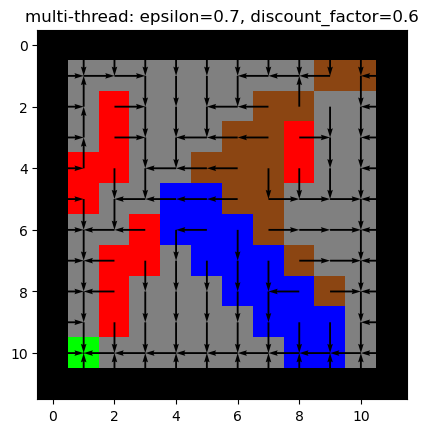

In [14]:
graph(q_values, save=True, title="multi-thread: epsilon=0.7, discount_factor=0.6")

# Q-Learning Single Threaded
<br>

In [15]:
q_values = np.zeros((environment_rows, environment_columns, 4))

q_values = q_learn_single(0.9, 0.7, 0.1, 1000)

Training Progress: 100%|████████████████████████████████████| 1000/1000 [00:37<00:00, 26.43epochs/s]

Training complete!


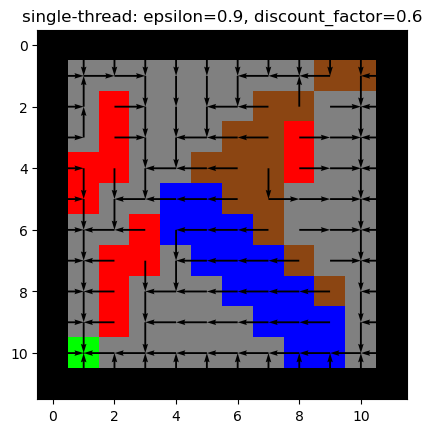

In [16]:
graph(q_values, save=True, title="single-thread: epsilon=0.9, discount_factor=0.6")